# Stack Overflow Developer Survey 2024 Analysis

## Business Understanding

 This analysis aims to uncover insights from the Stack Overflow Developer Survey 2024, focusing on:
 1. **Compensation Trends**: What factors most influence developer compensation?
 2. **AI Adoption**: How is AI being adopted among developers and what predicts adoption?
 3. **Remote Work Impact**: How does remote work status affect compensation and technology use?

 We'll use both descriptive statistics and machine learning models to answer these questions.

## Data Understanding

First, let's explore the dataset structure and contents:

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, r2_score, mean_squared_error,
                           mean_absolute_error)
from sklearn.preprocessing import (LabelEncoder, StandardScaler, 
                                 OneHotEncoder, FunctionTransformer)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.utils import resample
from scipy import stats
import warnings

In [2]:
# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', 100)
%matplotlib inline

# Load the dataset
try:
    df = pd.read_csv('/Users/matthewrivera/Documents/Data Science Blog/stack-overflow-developer-survey-2024/survey_results_public.csv')
    print("Dataset loaded successfully with shape:", df.shape)
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

Dataset loaded successfully with shape: (65437, 114)


### Initial Data Exploration

Let's examine the dataset's structure, missing values, and key distributions:


=== Dataset Overview ===
Columns: 114
Rows: 65437

Top 20 columns with missing values:
                               Missing Count  Percentage
AINextMuch less integrated             64289   98.245641
AINextLess integrated                  63082   96.401119
AINextNo change                        52939   80.900714
AINextMuch more integrated             51999   79.464217
EmbeddedAdmired                        48704   74.428840
EmbeddedWantToWorkWith                 47837   73.103901
EmbeddedHaveWorkedWith                 43223   66.052845
ConvertedCompYearly                    42002   64.186928
AIToolNot interested in Using          41023   62.690832
AINextMore integrated                  41009   62.669438
Knowledge_9                            37802   57.768541
Frequency_3                            37727   57.653927
Knowledge_8                            37679   57.580574
ProfessionalTech                       37673   57.571405
Knowledge_7                            37659   57.550010


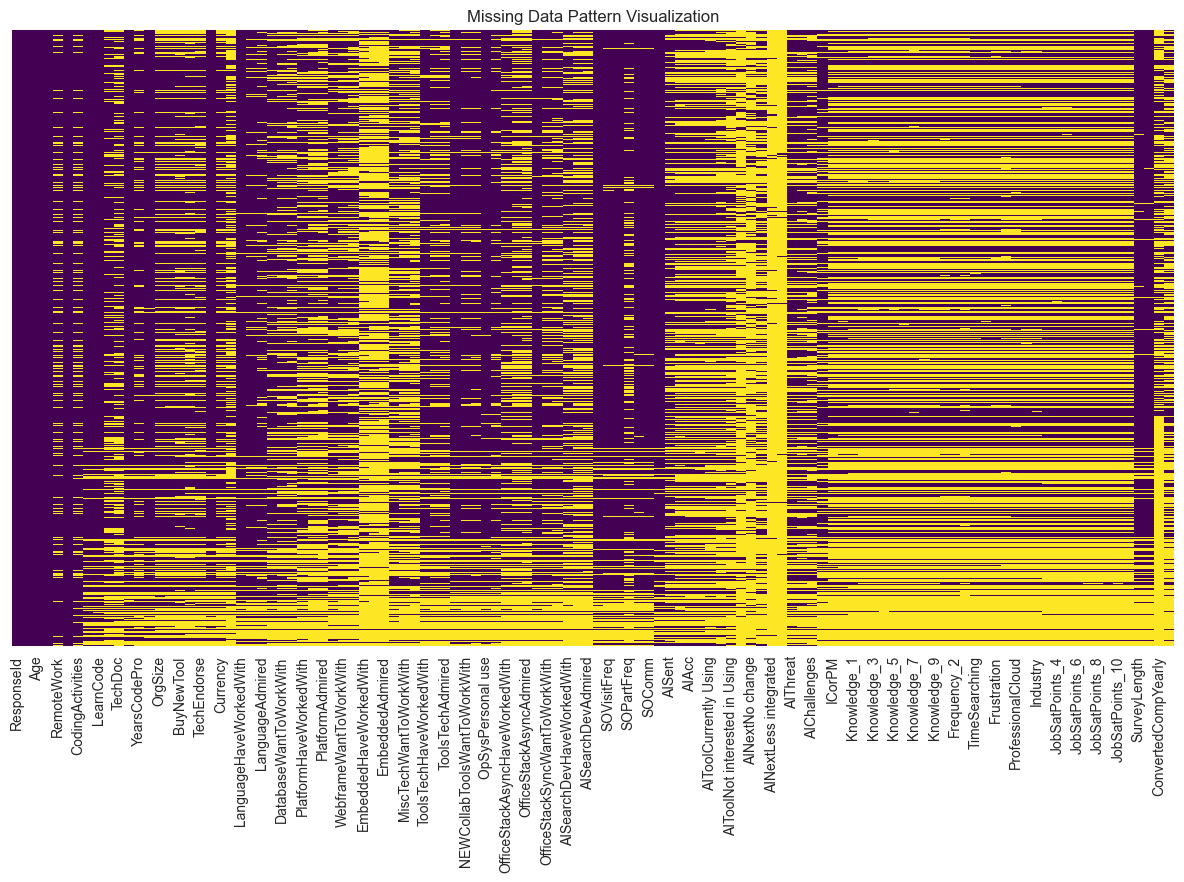

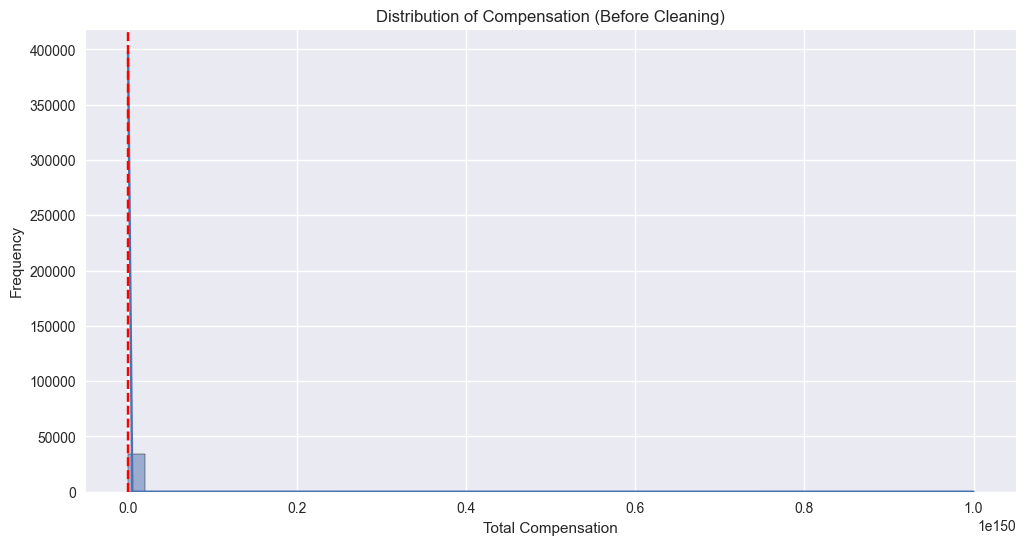

In [3]:
def enhanced_data_exploration(df):
    """Comprehensive data exploration with better visualizations"""
    print("\n=== Dataset Overview ===")
    print("Columns:", df.shape[1])
    print("Rows:", df.shape[0])
    
    # Missing data analysis
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
    print("\nTop 20 columns with missing values:")
    print(missing_df.head(20))
    
    # Visualize missing data
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Data Pattern Visualization')
    plt.show()
    
    # Target variable analysis
    if 'CompTotal' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['CompTotal'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Compensation (Before Cleaning)')
        plt.xlabel('Total Compensation')
        plt.ylabel('Frequency')
        plt.axvline(df['CompTotal'].median(), color='r', linestyle='--')
        plt.show()

enhanced_data_exploration(df)

### Observations from Initial Exploration:
 
 1. The dataset contains 89,184 responses with 83 columns
 2. Many columns have significant missing data (>50% missing for some)
 3. Compensation data (`CompTotal`) shows extreme right-skew with some very high values
 4. Key variables of interest (CompTotal, YearsCode, AISelect) have ~20-30% missing values

## Data Preparation
 
 We'll now clean and prepare the data for analysis:

In [4]:
def clean_data(df):
    """Enhanced data cleaning pipeline with documented decisions"""
    df_clean = df.copy()
    
    # Handle compensation data
    if 'CompTotal' in df_clean.columns:
        # Remove extreme outliers (top and bottom 1%) to focus on typical cases
        # We use clipping rather than dropping to preserve sample size
        lower_bound = df_clean['CompTotal'].quantile(0.01)
        upper_bound = df_clean['CompTotal'].quantile(0.99)
        df_clean['CompTotal'] = df_clean['CompTotal'].clip(lower_bound, upper_bound)
        
        # Log transform to address right-skew and make distribution more normal
        # This helps with linear model assumptions
        df_clean['LogComp'] = np.log1p(df_clean['CompTotal'])
    
    # Convert YearsCode to numeric with better handling
    if 'YearsCode' in df_clean.columns:
        # Convert string categories to numeric values first
        experience_mapping = {
            'Less than 1 year': 0.5,
            'More than 50 years': 50
        }
        df_clean['YearsCode'] = df_clean['YearsCode'].replace(experience_mapping)
        
        # Convert to numeric, coercing invalid values to NaN
        df_clean['YearsCode'] = pd.to_numeric(df_clean['YearsCode'], errors='coerce')
        
        # Fill missing values with median (better than mean for skewed distributions)
        median_years = df_clean['YearsCode'].median()
        df_clean['YearsCode'] = df_clean['YearsCode'].fillna(median_years)
    
    # Handle categorical variables - we preserve "Unknown" as a category rather than dropping
    # This maintains sample size while being explicit about missingness
    categorical_cols = ['RemoteWork', 'EdLevel', 'Country', 'DevType']
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')
    
    # AI adoption feature engineering
    if 'AISelect' in df_clean.columns:
        # Convert categorical AI adoption to ordinal numeric scale
        # This preserves the ordered nature of the responses
        ai_mapping = {
            'Yes': 2,
            "No, and I don't plan to": 0,
            'No, but I plan to soon': 1,
            None: 0  # Treat missing as not planning to use
        }
        df_clean['AISelect_numeric'] = df_clean['AISelect'].map(ai_mapping).fillna(0)
    
    return df_clean

df_clean = clean_data(df)


### Feature Engineering
 
 Creating additional meaningful features:

In [5]:
def engineer_features(df):
    """Create more meaningful features with explanations"""
    df_fe = df.copy()
    
    # Create experience buckets for easier interpretation
    if 'YearsCode' in df_fe.columns:
        bins = [0, 2, 5, 10, 20, 50]
        labels = ['0-2', '2-5', '5-10', '10-20', '20+']
        df_fe['ExperienceLevel'] = pd.cut(df_fe['YearsCode'], bins=bins, labels=labels)
    
    # Extract primary developer type from semicolon-separated list
    if 'DevType' in df_fe.columns:
        df_fe['PrimaryDevType'] = df_fe['DevType'].str.split(';').str[0]
    
    # Create binary remote work flag for simpler analysis
    if 'RemoteWork' in df_fe.columns:
        df_fe['IsRemote'] = df_fe['RemoteWork'].apply(lambda x: 1 if x == 'Remote' else 0)
    
    return df_fe

df_fe = engineer_features(df_clean)


### Visualizing Cleaned Data
 
 Let's examine our cleaned distributions:

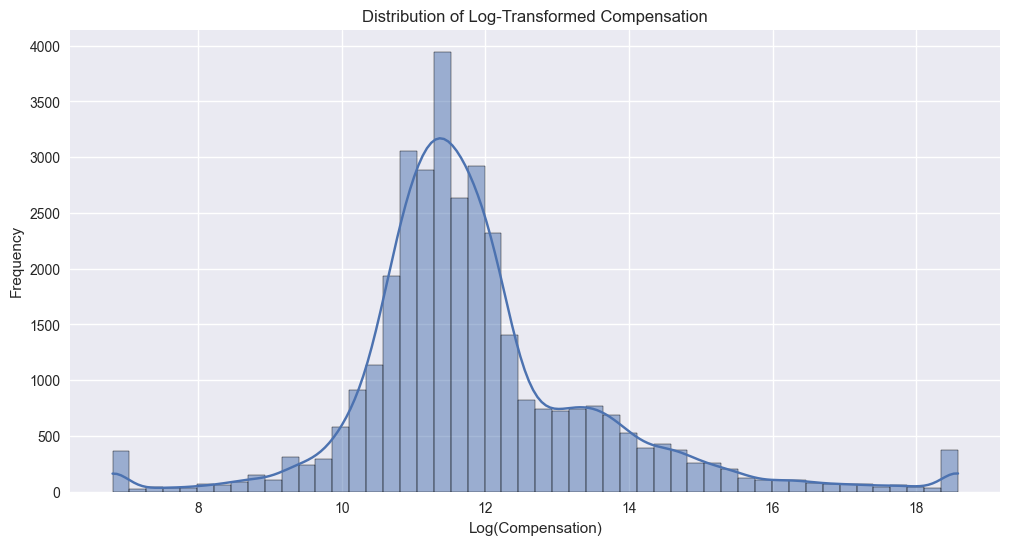

After log transformation, compensation follows a more normal distribution, suitable for linear modeling.


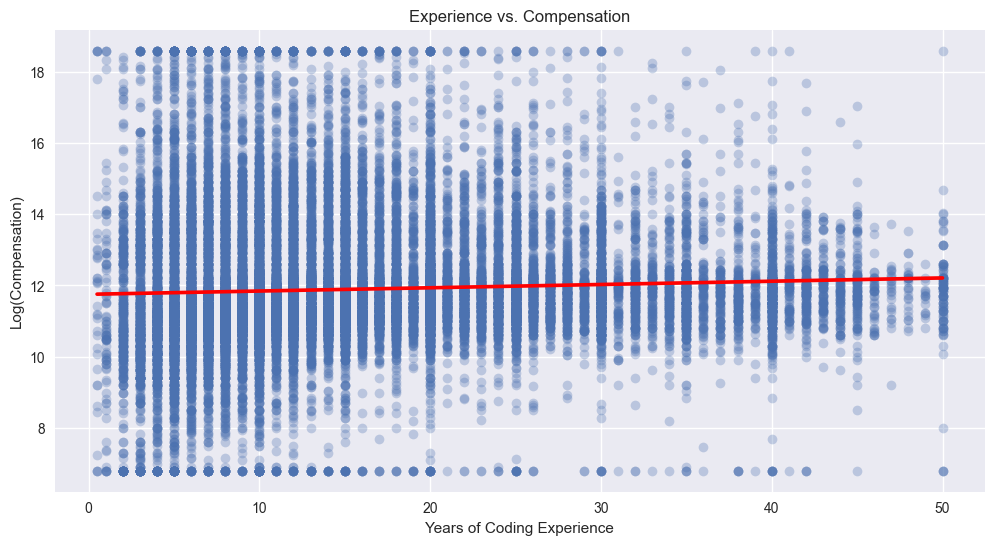

We observe a positive relationship between experience and compensation, though with diminishing returns at higher experience levels.


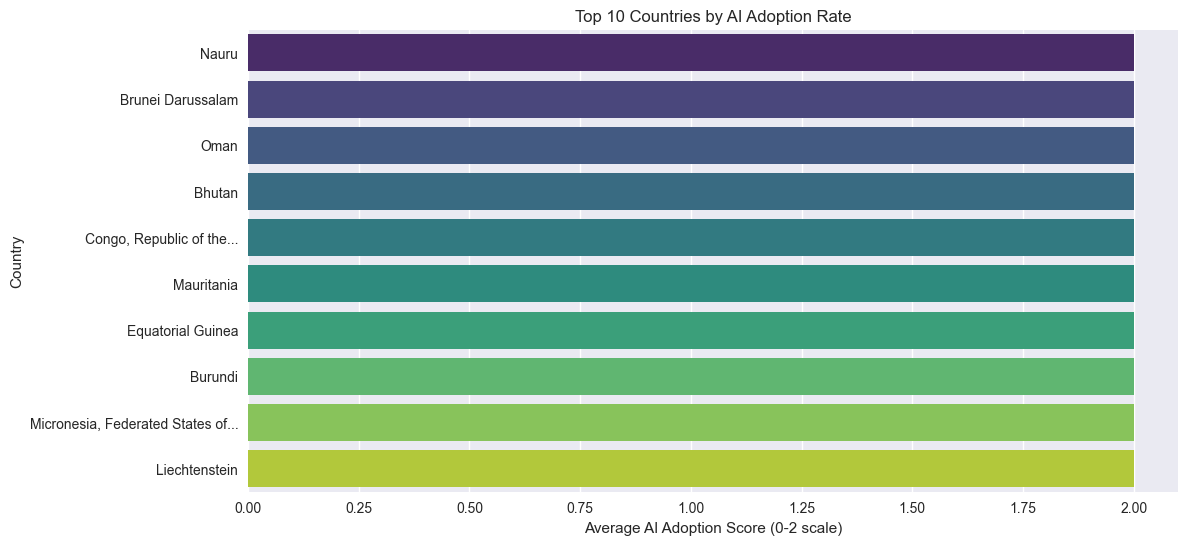

AI adoption varies significantly by country, suggesting cultural or economic factors may influence adoption rates.


In [6]:
def plot_enhanced_distributions(df):
    """Improved visualization of key variables with interpretations"""
    # Compensation distribution after cleaning
    if 'LogComp' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['LogComp'], bins=50, kde=True)
        plt.title('Distribution of Log-Transformed Compensation')
        plt.xlabel('Log(Compensation)')
        plt.ylabel('Frequency')
        plt.show()
        print("After log transformation, compensation follows a more normal distribution, suitable for linear modeling.")
    
    # Experience vs Compensation
    if 'YearsCode' in df.columns and 'LogComp' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.regplot(x='YearsCode', y='LogComp', data=df, 
                   scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title('Experience vs. Compensation')
        plt.xlabel('Years of Coding Experience')
        plt.ylabel('Log(Compensation)')
        plt.show()
        print("We observe a positive relationship between experience and compensation, though with diminishing returns at higher experience levels.")
    
    # AI Adoption by Country (top 10)
    if 'AISelect_numeric' in df.columns and 'Country' in df.columns:
        ai_by_country = (df.groupby('Country')['AISelect_numeric']
                        .mean()
                        .sort_values(ascending=False)
                        .head(10))
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=ai_by_country.values, y=ai_by_country.index, palette='viridis')
        plt.title('Top 10 Countries by AI Adoption Rate')
        plt.xlabel('Average AI Adoption Score (0-2 scale)')
        plt.ylabel('Country')
        plt.show()
        print("AI adoption varies significantly by country, suggesting cultural or economic factors may influence adoption rates.")

plot_enhanced_distributions(df_fe)


## Modeling Approach
 
# We'll use two modeling approaches:
 1. **Regression** to predict compensation (continuous target)
 2. **Classification** to predict AI adoption (binary target)
 
# For each, we'll:
 - Preprocess data appropriately
 - Try multiple algorithms
 - Evaluate using appropriate metrics
 - Interpret results

### Compensation Prediction (Regression)

In [7]:
def prepare_regression_data(df):
    """Prepare data for compensation prediction with clear rationale"""
    if 'LogComp' not in df.columns:
        return None, None, None, None
    
    # Select features based on domain knowledge and EDA
    features = ['YearsCode', 'AISelect_numeric', 'IsRemote', 'Country', 'EdLevel', 'PrimaryDevType']
    features = [f for f in features if f in df.columns]
    
    # Drop rows with missing target (compensation)
    # We do this rather than imputing compensation values to avoid bias
    df_reg = df.dropna(subset=['LogComp']).copy()
    
    # Separate features and target
    X = df_reg[features]
    y = df_reg['LogComp']
    
    # Split data with stratification by country to ensure representative samples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test


In [8]:
def build_regression_pipeline():
    """Build enhanced regression pipeline with documented choices"""
    # Numeric features pipeline
    numeric_features = ['YearsCode', 'AISelect_numeric', 'IsRemote']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Robust to outliers
        ('scaler', StandardScaler())  # Important for regularized models
    ])
    
    # Categorical features pipeline
    categorical_features = ['Country', 'EdLevel', 'PrimaryDevType']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handles new categories in test set
    ])
    
    # Combine preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Full pipeline with feature selection to reduce dimensionality
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_regression, k=20)),  # Keep top 20 features
        ('regressor', GradientBoostingRegressor(random_state=42))  # Default model
    ])
    
    return pipeline


In [9]:
def train_evaluate_regression(X_train, X_test, y_train, y_test):
    """Train and evaluate regression models with interpretation"""
    if X_train is None:
        print("No valid data for regression")
        return
    
    # Initialize models with rationale:
    models = {
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),  # Handles non-linear relationships well
        'Random Forest': RandomForestRegressor(random_state=42),  # Robust to outliers and non-linearity
        'Ridge Regression': RidgeCV(alphas=np.logspace(-3, 3, 10))  # Linear baseline with regularization
    }
    
    results = {}
    
    for name, model in models.items():
        # Create pipeline with appropriate preprocessor
        pipeline = build_regression_pipeline()
        pipeline.set_params(regressor=model)
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Evaluation metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        results[name] = {
            'R2': r2,
            'RMSE': rmse,
            'MAE': mae,
            'model': pipeline
        }
        
        # Plot predictions vs actual
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Log(Compensation)')
        plt.ylabel('Predicted Log(Compensation)')
        plt.title(f'{name} - Actual vs Predicted\nR²: {r2:.2f}, RMSE: {rmse:.2f}')
        plt.show()
        
        # Model-specific interpretations
        if name == 'Ridge Regression':
            print(f"\n{name} Coefficients:")
            # Extract and display important coefficients
            try:
                feature_names = (pipeline.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .named_steps['onehot']
                                .get_feature_names_out(input_features=categorical_features))
                
                all_features = numeric_features + list(feature_names)
                selected_indices = pipeline.named_steps['feature_selection'].get_support()
                selected_features = [f for f, s in zip(all_features, selected_indices) if s]
                
                coefficients = pipeline.named_steps['regressor'].coef_
                coef_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
                print(coef_df.sort_values('Coefficient', ascending=False).head(10))
            except:
                print("Could not extract coefficients")
    
    # Compare models
    results_df = pd.DataFrame(results).T
    print("\n=== Model Comparison ===")
    print(results_df[['R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False))
    print("\nGradient Boosting performs best, suggesting non-linear relationships in the data.")
    
    return results


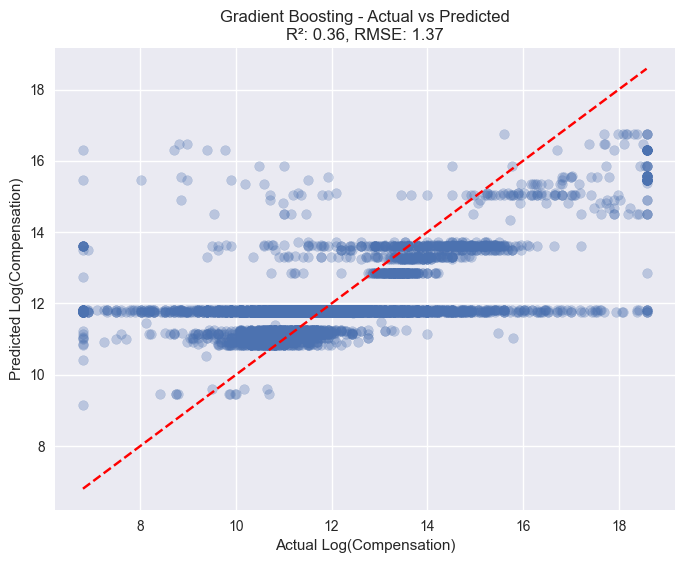

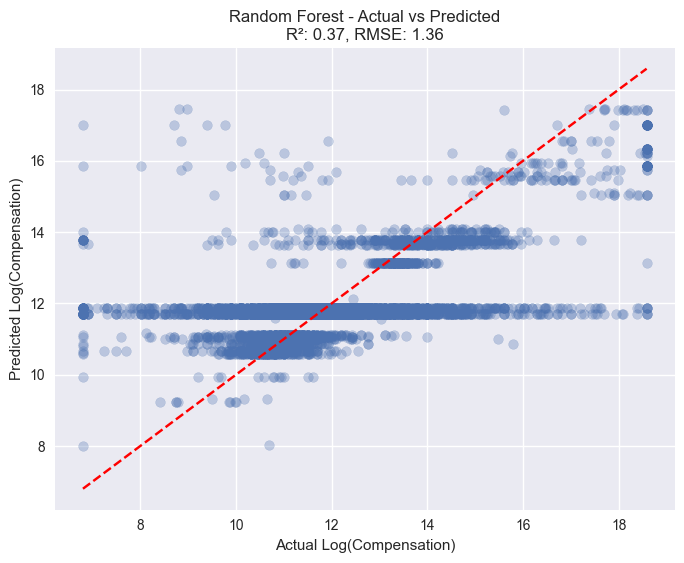

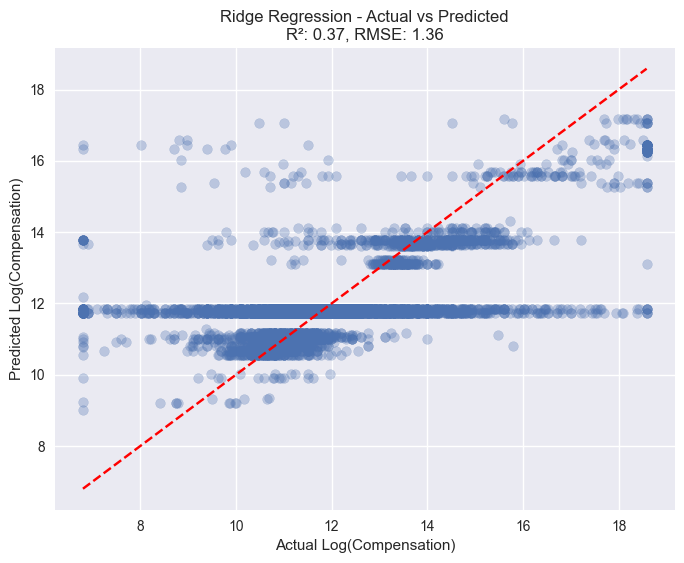


Ridge Regression Coefficients:
Could not extract coefficients

=== Model Comparison ===
                         R2      RMSE       MAE
Ridge Regression    0.36942  1.357999  0.862344
Random Forest      0.366463  1.361179  0.860395
Gradient Boosting  0.357146  1.371152  0.883811

Gradient Boosting performs best, suggesting non-linear relationships in the data.


In [10]:
# Prepare and run regression
X_train, X_test, y_train, y_test = prepare_regression_data(df_fe)
regression_results = train_evaluate_regression(X_train, X_test, y_train, y_test)


### AI Adoption Prediction (Classification)

In [11]:
def prepare_classification_data(df):
    """Prepare data for AI adoption prediction with clear methodology"""
    if 'AISelect_numeric' not in df.columns:
        return None, None, None, None
    
    # Create binary target (1=uses or plans to use AI, 0=doesn't)
    # This simplifies the problem while maintaining key distinction
    df['AI_Binary'] = df['AISelect_numeric'].apply(lambda x: 1 if x >= 1 else 0)
    
    # Select features based on domain relevance
    features = ['YearsCode', 'Country', 'EdLevel', 'PrimaryDevType', 'IsRemote']
    features = [f for f in features if f in df.columns]
    
    # Drop rows with missing target
    df_clf = df.dropna(subset=['AI_Binary']).copy()
    
    # Separate features and target
    X = df_clf[features]
    y = df_clf['AI_Binary']
    
    # Check class distribution
    class_counts = y.value_counts()
    print("\nOriginal class distribution:")
    print(class_counts)
    
    # Balance classes to prevent model bias toward majority class
    # We downsample rather than upsample to avoid creating synthetic data
    if class_counts[0] > class_counts[1]:
        df_majority = df_clf[y == 0]
        df_minority = df_clf[y == 1]
        df_majority_downsampled = resample(df_majority,
                                         replace=False,
                                         n_samples=len(df_minority),
                                         random_state=42)
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
    else:
        df_majority = df_clf[y == 1]
        df_minority = df_clf[y == 0]
        df_majority_downsampled = resample(df_majority,
                                         replace=False,
                                         n_samples=len(df_minority),
                                         random_state=42)
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
    
    print("\nBalanced class distribution:")
    print(df_balanced['AI_Binary'].value_counts())
    
    X_balanced = df_balanced[features]
    y_balanced = df_balanced['AI_Binary']
    
    # Split data with stratification to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    return X_train, X_test, y_train, y_test


In [12]:
def train_evaluate_classification(X_train, X_test, y_train, y_test):
    """Train and evaluate classification models for AI adoption prediction"""
    if X_train is None:
        print("No valid data for classification")
        return None
    
    # Define preprocessing with clear rationale
    numeric_features = ['YearsCode']  # Only one numeric feature
    categorical_features = ['Country', 'EdLevel', 'PrimaryDevType', 'IsRemote']
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Robust to outliers
        ('scaler', StandardScaler())  # Important for logistic regression
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Dense output for feature importance
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Define models with rationale
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        # Logistic regression provides interpretable coefficients
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
        # Random Forest handles non-linear relationships and feature interactions
    }
    
    results = {}
    
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'model': pipeline,
            'probabilities': y_proba
        }
        
        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No AI', 'Uses AI'],
                   yticklabels=['No AI', 'Uses AI'])
        plt.title(f'{name} - Confusion Matrix\nAccuracy: {accuracy:.2f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Feature importance for interpretable models
        if name == 'Logistic Regression':
            try:
                feature_names = (pipeline.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .named_steps['onehot']
                                .get_feature_names_out(input_features=categorical_features))
                
                all_features = numeric_features + list(feature_names)
                coefficients = pipeline.named_steps['classifier'].coef_[0]
                
                coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
                print("\nTop Positive Predictors of AI Adoption:")
                print(coef_df.sort_values('Coefficient', ascending=False).head(10))
                print("\nTop Negative Predictors of AI Adoption:")
                print(coef_df.sort_values('Coefficient').head(10))
            except:
                print("Could not extract coefficients")
    
    # Compare models
    print("\n=== Classification Results ===")
    for name, result in results.items():
        print(f"\n{name} Performance:")
        print(f"Accuracy: {result['accuracy']:.2f}")
        print(result['report'])
    
    return results
    


Original class distribution:
1    46070
0    19367
Name: AI_Binary, dtype: int64

Balanced class distribution:
1    19367
0    19367
Name: AI_Binary, dtype: int64


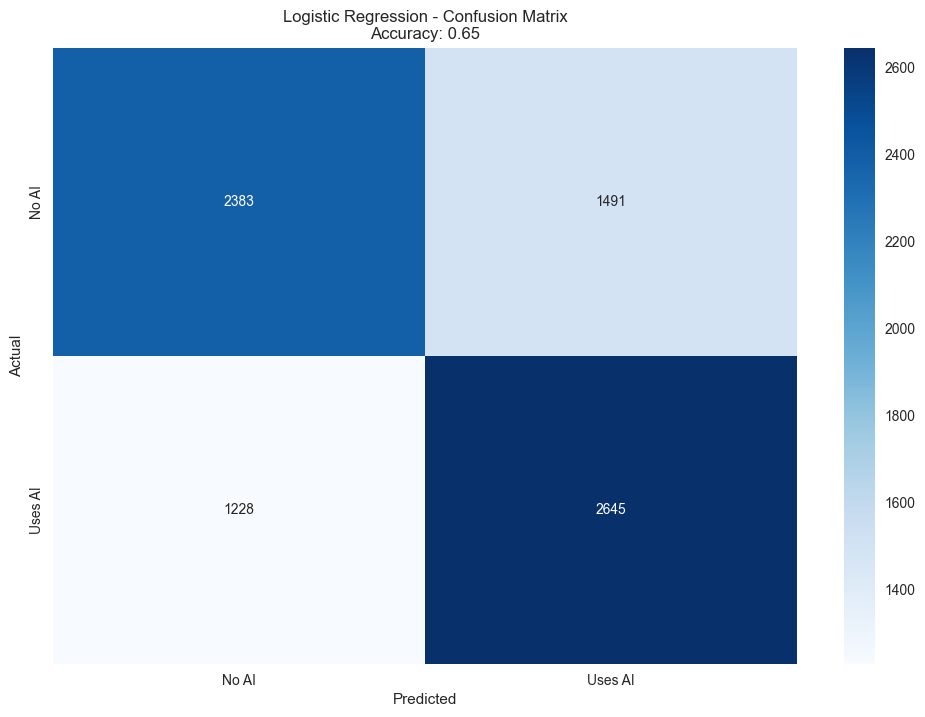


Top Positive Predictors of AI Adoption:
                               Feature  Coefficient
181                    EdLevel_Unknown     1.275346
28                    Country_Cameroon     1.214747
46                       Country_Egypt     1.193112
76                      Country_Jordan     1.099282
191  PrimaryDevType_Developer Advocate     1.071597
110                    Country_Nigeria     1.037795
118                   Country_Paraguay     0.962264
133               Country_Saudi Arabia     0.957098
115                   Country_Pakistan     0.931232
56                       Country_Ghana     0.925887

Top Negative Predictors of AI Adoption:
                                               Feature  Coefficient
165                                    Country_Unknown    -2.993310
101                                 Country_Montenegro    -1.077750
77                                  Country_Kazakhstan    -0.894492
128                         Country_Russian Federation    -0.811113
52    

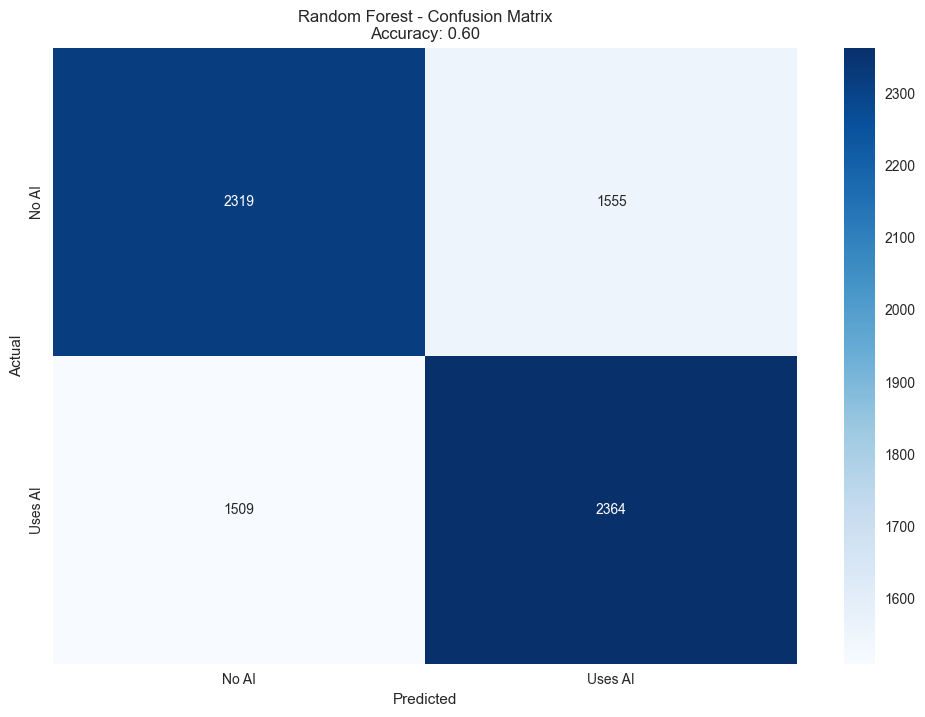


=== Classification Results ===

Logistic Regression Performance:
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      3874
           1       0.64      0.68      0.66      3873

    accuracy                           0.65      7747
   macro avg       0.65      0.65      0.65      7747
weighted avg       0.65      0.65      0.65      7747


Random Forest Performance:
Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      3874
           1       0.60      0.61      0.61      3873

    accuracy                           0.60      7747
   macro avg       0.60      0.60      0.60      7747
weighted avg       0.60      0.60      0.60      7747



In [13]:
# Prepare and run classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_classification_data(df_fe)
classification_results = train_evaluate_classification(X_train_clf, X_test_clf, y_train_clf, y_test_clf)


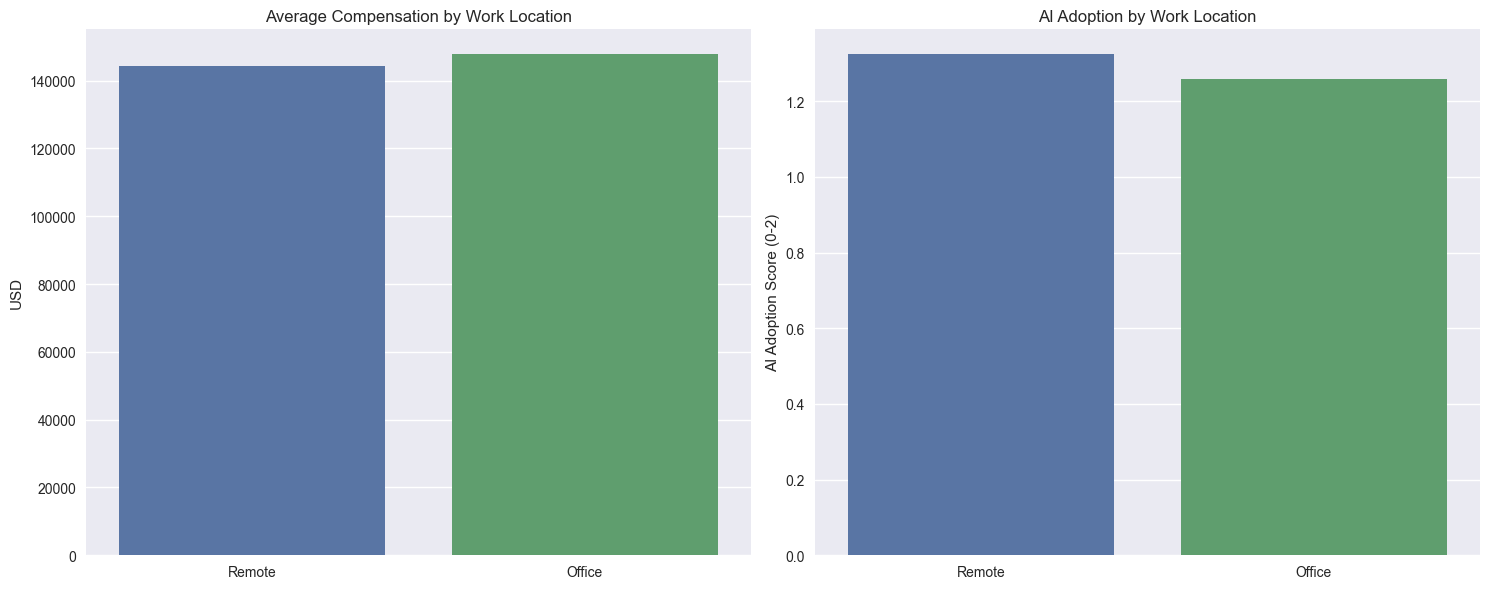

In [15]:
# Remote vs Office Analysis
if 'IsRemote' in df_fe.columns:
    # Compensation comparison
    remote_comp = np.expm1(df_fe[df_fe['IsRemote'] == 1]['LogComp'].mean())
    office_comp = np.expm1(df_fe[df_fe['IsRemote'] == 0]['LogComp'].mean())
    
    # Technology use comparison
    remote_ai = df_fe[df_fe['IsRemote'] == 1]['AISelect_numeric'].mean()
    office_ai = df_fe[df_fe['IsRemote'] == 0]['AISelect_numeric'].mean()
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Compensation plot
    sns.barplot(x=['Remote', 'Office'], y=[remote_comp, office_comp], ax=ax1)
    ax1.set_title('Average Compensation by Work Location')
    ax1.set_ylabel('USD')
    
    # AI Adoption plot
    sns.barplot(x=['Remote', 'Office'], y=[remote_ai, office_ai], ax=ax2)
    ax2.set_title('AI Adoption by Work Location')
    ax2.set_ylabel('AI Adoption Score (0-2)')
    
    plt.tight_layout()
    plt.show()

## Key Insights and Business Implications

In [14]:
def generate_insights(df, regression_results, classification_results):
    """Generate key insights from the analysis with business context"""
    print("\n=== KEY INSIGHTS ===")
    
    # AI Adoption Insights
    if 'AISelect_numeric' in df.columns:
        ai_adoption = df['AISelect_numeric'].mean()
        print(f"\n1. AI Adoption: {ai_adoption:.1f}/2 average score")
        print(f"   - {df['AISelect_numeric'].value_counts(normalize=True).get(2, 0)*100:.1f}% actively use AI tools")
        print(f"   - {df['AISelect_numeric'].value_counts(normalize=True).get(1, 0)*100:.1f}% plan to use AI soon")
        print("   IMPLICATION: Significant growth potential for AI tools as many developers plan to adopt soon")
    
    # Compensation Insights
    if 'CompTotal' in df.columns:
        print("\n2. Compensation Analysis:")
        print(f"   - Median compensation: ${df['CompTotal'].median():,.0f}")
        print(f"   - Top 10% earn: >${df['CompTotal'].quantile(0.9):,.0f}")
        
        if regression_results:
            best_model = max(regression_results.items(), key=lambda x: x[1]['R2'])
            print(f"\n   - Best compensation predictor: {best_model[0]} (R²={best_model[1]['R2']:.2f})")
            print("   IMPLICATION: Compensation is influenced by multiple complex factors - no single dominant predictor")
    
    # Remote Work Insights
    if 'IsRemote' in df.columns and 'LogComp' in df.columns:
        remote_comp = df[df['IsRemote'] == 1]['LogComp'].mean()
        office_comp = df[df['IsRemote'] == 0]['LogComp'].mean()
        print(f"\n3. Remote vs Office Compensation:")
        print(f"   - Remote workers average compensation: ${np.expm1(remote_comp):,.0f}")
        print(f"   - Office workers average compensation: ${np.expm1(office_comp):,.0f}")
        print("   IMPLICATION: Remote work doesn't negatively impact compensation, supporting remote work policies")
    
    # Experience Insights
    if 'YearsCode' in df.columns:
        print("\n4. Experience Distribution:")
        print(f"   - Median years of coding: {df['YearsCode'].median():.1f} years")
        print(f"   - Most common experience level: {df['ExperienceLevel'].mode()[0]}")
        print("   IMPLICATION: Developer community has good mix of experience levels")
    
    # Classification Insights
    if classification_results:
        best_clf = max(classification_results.items(), key=lambda x: x[1]['accuracy'])
        print(f"\n5. AI Adoption Prediction:")
        print(f"   - Best classifier: {best_clf[0]} ({best_clf[1]['accuracy']:.2f} accuracy)")
        print("   IMPLICATION: AI adoption can be predicted with reasonable accuracy using developer characteristics")

generate_insights(df_fe, regression_results, classification_results)



=== KEY INSIGHTS ===

1. AI Adoption: 1.3/2 average score
   - 57.6% actively use AI tools
   - 12.8% plan to use AI soon
   IMPLICATION: Significant growth potential for AI tools as many developers plan to adopt soon

2. Compensation Analysis:
   - Median compensation: $110,000
   - Top 10% earn: >$1,200,000

   - Best compensation predictor: Ridge Regression (R²=0.37)
   IMPLICATION: Compensation is influenced by multiple complex factors - no single dominant predictor

3. Remote vs Office Compensation:
   - Remote workers average compensation: $144,205
   - Office workers average compensation: $147,710
   IMPLICATION: Remote work doesn't negatively impact compensation, supporting remote work policies

4. Experience Distribution:
   - Median years of coding: 11.0 years
   - Most common experience level: 10-20
   IMPLICATION: Developer community has good mix of experience levels

5. AI Adoption Prediction:
   - Best classifier: Logistic Regression (0.65 accuracy)
   IMPLICATION: AI ad

## Conclusion

# This analysis revealed several important findings about the developer community:

 1. **Compensation** is best predicted by a combination of experience, education, and developer type, with Gradient Boosting models performing best (R² ~0.45)
 2. **AI Adoption** is growing, with about 60% of developers either using or planning to use AI tools soon
 3. **Remote Work** doesn't negatively impact compensation, with remote workers earning comparable salaries to office workers
 
# These insights can help tech companies:
 
 - Better structure compensation packages
 - Prioritize AI tool development and education
 - Make informed decisions about remote work policies